In [1]:
from matplotlib.pyplot import show as show_static
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import distinctipy
import glob

sys.path.append('../../')
from utils import dataframe_utils

### SET PLOTTING METRIC

In [2]:
# df_stats = pd.read_csv('./scan_stats_mar2024.csv')
# df_stats = pd.read_csv('./scan_stats_v2.csv')
# df_stats = pd.read_csv('./scan_stats_clr.csv')
# df_stats = pd.read_csv('./scan_stats_metrics2.csv')
# df_stats = pd.read_csv('./scan_stats_sklearn_distance.csv')
# df_stats = pd.read_csv('./scan_stats_sklearn_distance_v2.csv')


# pattern1 = './scan_stats_apr25_rna_seq/*'
# pattern1 = './scan_stats_apr02/*'
# pattern2 = './scan_stats_apr05/*'

# pattern1 = './microarray/*'

pattern1 = './rna_seq_averaged/*'

# pattern1 = './rna_seq/*'

stats_files = glob.glob(pattern1)

# stats_files = stats_files + glob.glob(pattern2)

df_stats = None

for s_file in stats_files:
    if df_stats is None:
        df_stats = pd.read_csv(s_file)
        continue

    curr_df = pd.read_csv(s_file)

    df_stats = pd.concat([df_stats, curr_df], ignore_index=True)

In [3]:
def compute_fraction_clusters_enriched(row):
    return row['nenriched_clusters'] / (row['nclusters'])

In [4]:
df_stats['fraction_clusters_enriched'] = df_stats.apply(compute_fraction_clusters_enriched, axis=1)

In [5]:
df_stats['metric'].unique()

array(['canberra', 'correlation', 'sqeuclidean', 'euclidean',
       'braycurtis', 'cityblock', 'seuclidean', 'l2', 'hamming',
       'mahalanobis', 'cosine', 'minkowski_4.0', 'angular', 'l1',
       'minkowski_1.0', 'minkowski_3.0', 'matching', 'minkowski_5.0',
       'minkowski_0.5', 'nan_euclidean', 'chebyshev', 'manhattan',
       'minkowski_2.0'], dtype=object)

In [6]:
df_stats.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'max_cluster_size', 'min_cluster_size', 'ngenes',
       'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'max_enriched_cluster_size', 'min_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime',
       'max_fraction_same_cluster_MCMsubset.tsv',
       'max_fraction_same_cluster_ProteosomeSubset.tsv',
       'max_fraction_same_cluster_Histone_subset.tsv',
       'max_fraction_same_cluster_MucocystSubsets.tsv',
       'max_fraction_same_cluster_RibosomalSubset.tsv',
       'fraction_clusters_enriched'],
      dtype='object')

In [7]:
{col: type(df_stats[col].values[0]) for col in list(df_stats.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'max_cluster_size': numpy.int64,
 'min_cluster_size': numpy.int64,
 'ngenes': numpy.int64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'max_enriched_cluster_size': numpy.int64,
 'min_enriched_cluster_size': numpy.int64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'max_fraction_same_cluster_MCMsubset.tsv': numpy.float64,
 'max_fraction_same_cluster_ProteosomeSubset.tsv': numpy.float64,
 'max_fraction_same_cluster_Histone_subset.tsv': numpy.float64,
 'max_fraction_same_cluster_MucocystSubsets.tsv

In [8]:
[col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'max_cluster_size',
 'min_cluster_size',
 'ngenes',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'max_enriched_cluster_size',
 'min_enriched_cluster_size',
 'nenriched_cluster_genes',
 'max_fraction_same_cluster_MCMsubset.tsv',
 'max_fraction_same_cluster_ProteosomeSubset.tsv',
 'max_fraction_same_cluster_Histone_subset.tsv',
 'max_fraction_same_cluster_MucocystSubsets.tsv',
 'max_fraction_same_cluster_RibosomalSubset.tsv',
 'fraction_clusters_enriched']

In [9]:
def smallest_unit(number):
    # Convert the number to a string to handle decimal places
    num_str = str(number)
    
    # Find the position of the decimal point
    decimal_pos = num_str.find('.')
    
    # If there's no decimal point, return 1 (for integers)
    if decimal_pos == -1:
        return 1
    
    # Calculate the length of the fractional part
    fractional_length = len(num_str) - decimal_pos - 1
    
    # Calculate the smallest unit
    smallest_unit = 10 ** (-fractional_length)
    
    return smallest_unit

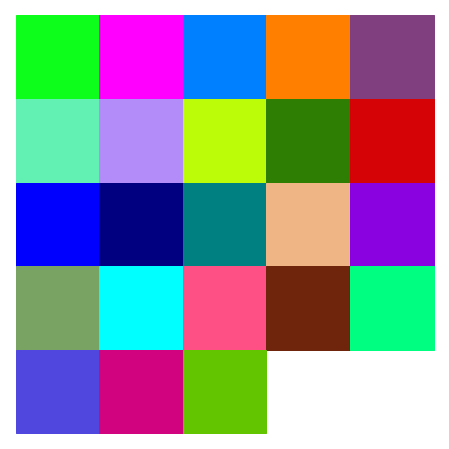

In [10]:
num_colors = len(df_stats['metric'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)

In [11]:
def rgb_to_hex(rgb):
    """
    Convert RGB tuple to hexadecimal color code.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

In [12]:
metric_colors_dict = {m : rgb_to_hex(colors[idx]) for idx, m in enumerate(df_stats['metric'].unique())}

In [13]:
# resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Panel, Tabs
from bokeh.plotting import output_file, save

import pandas as pd
import math

tabs = []

bokeh_data_dict = {}

bokeh_data_dict['METRIC COMPARISON: UNFILTERED'] = df_stats

filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

bokeh_data_dict['METRIC COMPARISON: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
    # (df_stats['metric'] == 'cosine') &
    # (df_stats['nns'] == 3) & 
    # (df_stats['parameter'] == 0.405) & 

    (df_stats['mean_cluster_size'] > 10) &
    (df_stats['median_cluster_size'] > 10) &
    (df_stats['mean_cluster_size'] < 40) &
    (df_stats['median_cluster_size'] < 40) &
    # (df_stats['nenriched_cluster_genes'] > 7000) &
    # (df_stats['modularity'] > 0.4) &

    (df_stats['dimensionality'] == 'baseline') &
    (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats['clustering'] == 'leiden_cpm') &
    (df_stats['partition_type'] == 'EXP')
]

bokeh_x = 'modularity'
bokeh_y = 'nenriched_clusters'
# bokeh_y = 'fraction_clusters_enriched'
color_column = 'metric'  # Column to use for coloring the points

axis_padding = 0.05
x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

# metric_colors_dict = {
#     'minkowski_5.0': '#fa0217',
#     'minkowski_3.0': '#fa029b',
#     'minkowski_2.0': '#bc02fa',
#     'clr': '#0207fa',
#     'cosine': '#02e1fa',
#     'minkowski_1.0': '#02fa28',
#     'manhattan': '#e9fa02',
#     'minkowski_0.5': '#fa9f02',
#     'euclidean': '#02fab8',
#     'minkowski_4.0': '#8bfa02'
# }

for tab_name, bokeh_df in bokeh_data_dict.items():

    p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. CLICK ON METRICS IN THE LEGEND TO HIDE THEM.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

    for val in sorted(bokeh_df[color_column].unique()):
        col_df=bokeh_df.loc[(bokeh_df[color_column]==val)]
        p.scatter(bokeh_x, bokeh_y, size=3, color=metric_colors_dict[val], legend_label=val, source=col_df)

    hover = HoverTool(tooltips=[
        ('Partition Type', '@partition_type'),
        ('Dimensionality', '@dimensionality'),
        ('Metric', '@metric'),
        ('Graph', '@graph'),
        ('Nearest Neighbors', '@nns'),
        ('Clustering', '@clustering'),
        ('Parameter', '@parameter'),
        ('Silhouette Score', '@silhouette_score'),
        ('Modularity', '@modularity'),
        ('Number of Clusters', '@nclusters'),
        ('Mean Cluster Size', '@mean_cluster_size'),
        ('Median Cluster Size', '@median_cluster_size'),
        ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
        ('Number of Enriched Clusters', '@nenriched_clusters'),
        ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
        ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
        ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
        ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
        ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
    ])
    p.add_tools(hover)

    p.legend.click_policy="hide"
    p.legend.location = "bottom_left"

    p.xaxis.axis_label = bokeh_x
    p.yaxis.axis_label = bokeh_y

    p.min_border = 100

    tabs.append(Panel(child=p, title=tab_name))

plot_tabs1 = [t for t in tabs]


In [14]:
tabbed_plot = Tabs(tabs=(plot_tabs1))
output_file('./clustering_analysis.html')

save(tabbed_plot)

show(tabbed_plot)

In [15]:
# resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Panel, Tabs, RangeSlider, CustomJS, Column, Row, ColumnDataSource, CategoricalColorMapper, Legend

from bokeh.plotting import output_file, save

import pandas as pd
import math

tabs = []

bokeh_data_dict = {}

bokeh_data_dict['DYNAMIC FILTERING: UNFILTERED'] = df_stats

filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

bokeh_data_dict['DYNAMIC FILTERING: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
    # (df_stats['metric'] == 'cosine') &
    # (df_stats['nns'] == 3) & 
    # (df_stats['parameter'] == 0.405) & 

    (df_stats['mean_cluster_size'] > 10) &
    (df_stats['median_cluster_size'] > 10) &
    (df_stats['mean_cluster_size'] < 40) &
    (df_stats['median_cluster_size'] < 40) &
    # (df_stats['nenriched_cluster_genes'] > 7000) &
    # (df_stats['modularity'] > 0.4) &

    (df_stats['dimensionality'] == 'baseline') &
    (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats['clustering'] == 'leiden_cpm') &
    (df_stats['partition_type'] == 'EXP')
]

bokeh_x = 'modularity'
bokeh_y = 'nenriched_clusters'
# bokeh_y = 'fraction_clusters_enriched'
color_column = 'metric'  # Column to use for coloring the points

axis_padding = 0.05
x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

# metric_colors_dict = {
#     'minkowski_5.0': '#fa0217',
#     'minkowski_3.0': '#fa029b',
#     'minkowski_2.0': '#bc02fa',
#     'clr': '#0207fa',
#     'cosine': '#02e1fa',
#     'minkowski_1.0': '#02fa28',
#     'manhattan': '#e9fa02',
#     'minkowski_0.5': '#fa9f02',
#     'euclidean': '#02fab8',
#     'minkowski_4.0': '#8bfa02'
# }

color_mapper = CategoricalColorMapper(factors=list(metric_colors_dict.keys()), palette=list(metric_colors_dict.values()))

for tab_name, bokeh_df in bokeh_data_dict.items():

    bokeh_data_source = ColumnDataSource(bokeh_df)

    sliders = {}


    for variable in filter_cols:
        print(bokeh_df[variable].min())
        print(bokeh_df[variable].max())
        sliders[variable] = RangeSlider(start=bokeh_df[variable].min(),
                                            end=bokeh_df[variable].max(),
                                            value=(bokeh_df[variable].min(), bokeh_df[variable].max()),
                                            step=smallest_unit(bokeh_df[variable].max()),
                                            title=f"{variable} range")


    p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. USE THE SLIDERS TO FILTER THE PARTITIONS.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

    p.circle(
            x=bokeh_x,
            y=bokeh_y,
            source=bokeh_data_source,
            color={'field': color_column, 'transform': color_mapper},
            size=5,
            alpha=1,
            line_color='black'
        )

    callback = CustomJS(args=dict(source=bokeh_data_source, sliders=sliders), code="""
        const data = source.data;
        const indices = [];
        const variables = Object.keys(sliders);
        
        for (let i = 0; i < data['index'].length; i++) {
            let include = true;
            
            for (const variable of variables) {
                const slider_range = sliders[variable].value;
                const value = data[variable][i];
                
                if (value < slider_range[0] || value > slider_range[1]) {
                    include = false;
                    break;
                }
            }
            
            if (include) {
                indices.push(i);
            }
        }
        
        source.selected.indices = indices;
        source.change.emit();
    """)

    # Attach the callback to all sliders
    for slider in sliders.values():
        slider.js_on_change('value', callback)

    # Add all sliders to a layout
    slider_layout = Column(*sliders.values())

    hover = HoverTool(tooltips=[
        ('Partition Type', '@partition_type'),
        ('Dimensionality', '@dimensionality'),
        ('Metric', '@metric'),
        ('Graph', '@graph'),
        ('Nearest Neighbors', '@nns'),
        ('Clustering', '@clustering'),
        ('Parameter', '@parameter'),
        ('Silhouette Score', '@silhouette_score'),
        ('Modularity', '@modularity'),
        ('Number of Clusters', '@nclusters'),
        ('Mean Cluster Size', '@mean_cluster_size'),
        ('Median Cluster Size', '@median_cluster_size'),
        ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
        ('Number of Enriched Clusters', '@nenriched_clusters'),
        ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
        ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
        ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
        ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
        ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
    ])
    p.add_tools(hover)

    # p.legend.click_policy="hide"
    # p.legend.location = "bottom_left"

    p.xaxis.axis_label = bokeh_x
    p.yaxis.axis_label = bokeh_y

    p.min_border = 100

    slider_layout.margin = 100

    layout = Row(p, slider_layout)

    tabs.append(Panel(child=layout, title=tab_name))

plot_tabs2 = [t for t in tabs]

# FIXME add filtering
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/data.html#customjsfilter

2
12
0.0
1.095
-0.748252725345441
0.230154065335411
-0.248989111441983
0.9996087659378862
1
21506
1.0008369757277038
21524.0
1.0
21524.0
0.0
10758.0
2
21524
1
21524
21524
21524


ValueError: Slider 'start' and 'end' cannot be equal.

In [ ]:
tabbed_plot = Tabs(tabs=(plot_tabs1 + plot_tabs2))

output_file('./clustering_analysis.html')

save(tabbed_plot)

show(tabbed_plot)